# Imports & constants

In [1]:
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim

N_PC = 100
FILTER_MIN_GENES = 1.8e3
FILTER_MIN_READS = 5
DO_STANDARDIZE = False

# Load data

In [2]:
datasets = {}

## Cleaning the data (filtering)

In [3]:
def remove_doublets(df_counts, df_meta):
    df_counts = df_counts.loc[:, df_meta['demuxlet_cls'] == 'SNG']
    df_meta = df_meta.loc[df_meta['demuxlet_cls'] == 'SNG', :]
    return df_counts, df_meta

def filter_cells(df_counts, df_meta, min_genes=FILTER_MIN_GENES):
    df_counts = df_counts.loc[:, df_counts.sum(axis=0) > min_genes]
    df_meta = df_meta.loc[df_counts.sum(axis=0) > min_genes, :]
    return df_counts, df_meta

def filter_genes(df, min_cells=FILTER_MIN_READS):
    df = df.loc[df.sum(axis=1) > min_cells, :]
    return df


## Kowalcyzk et al.

In [4]:
datasets['Kowalcyzk'] = defaultdict(dict)
counts = pd.read_csv('data/Kowalcyzk/Kowalcyzk_counts.csv', index_col=0)
meta = pd.read_csv('data/Kowalcyzk/Kowalcyzk_meta.csv', index_col=0)
print(counts.info())
counts, meta = filter_cells(counts, meta)
counts = filter_genes(counts)
print(counts.info())
print(meta.info())
for age in np.unique(meta['cell_age']):
    count_subset = counts.loc[:, meta['cell_age'] == age]
    print(count_subset.shape)
    meta_subset = meta.loc[meta['cell_age'] == age, :]
    print(meta_subset.shape)
    datasets['Kowalcyzk'][age]['counts'] = count_subset
    datasets['Kowalcyzk'][age]['meta'] = meta_subset

<class 'pandas.core.frame.DataFrame'>
Index: 8357 entries, Npl to Sft2d1
Columns: 1022 entries, young_LT_HSC_2 to old_MPP_180
dtypes: int64(1022)
memory usage: 65.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8357 entries, Npl to Sft2d1
Columns: 1022 entries, young_LT_HSC_2 to old_MPP_180
dtypes: int64(1022)
memory usage: 65.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1022 entries, young_LT_HSC_2 to old_MPP_180
Data columns (total 2 columns):
cell_age     1022 non-null object
cell_type    1022 non-null object
dtypes: object(2)
memory usage: 24.0+ KB
None
(8357, 524)
(524, 2)
(8357, 498)
(498, 2)


(1022, 8357)
fitting PCA
fitting UMAP
fitting tSNE
(1022, 100)


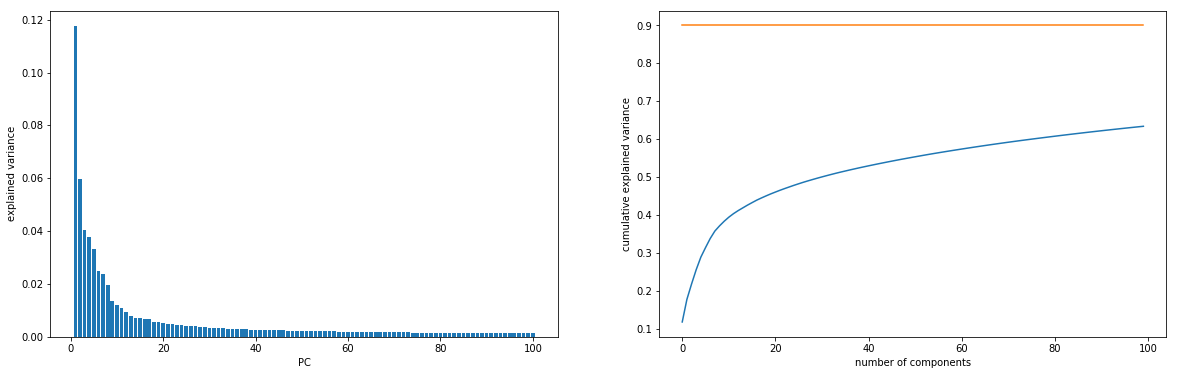

In [5]:
# Embed
n_cells = np.sum([datasets['Kowalcyzk'][batch]['counts'].shape[1] for batch in datasets['Kowalcyzk'].keys()])
X = np.zeros((n_cells, next(iter(datasets['Kowalcyzk'].values()))['counts'].shape[0]))
y_batch = []
y_cell_line = []
cur_idx = 0
for batch in datasets['Kowalcyzk'].keys():
    cur_size = datasets['Kowalcyzk'][batch]['counts'].shape[1]
    y_batch.extend([batch]*cur_size)
    y_cell_line.extend(datasets['Kowalcyzk'][batch]['meta']['cell_type'])
    X[cur_idx: cur_idx + cur_size] = datasets['Kowalcyzk'][batch]['counts'].T
    cur_idx += cur_size
y_batch = np.array(y_batch)
y_cell_line = np.array(y_cell_line)
assert(len(y_batch) == X.shape[0] and len(y_cell_line) == X.shape[0])
print(X.shape)
#X = StandardScaler().fit_transform(X)
print('fitting PCA')
pca_model = PCA(n_components=N_PC).fit(X)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
ax1.set_ylabel('explained variance')
ax1.set_xlabel('PC')
ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
ax2.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance')
#fig.show()

if DO_STANDARDIZE:
    X = StandardScaler().fit_transform(X)
    print('fitting PCA')
    pca_model = PCA(n_components=N_PC).fit(X)
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
    ax1.set_ylabel('explained variance')
    ax1.set_xlabel('PC')
    ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
    ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('cumulative explained variance')
X_pca = pca_model.transform(X)
print('fitting UMAP')
X_umap = umap.UMAP().fit_transform(X)
print('fitting tSNE')
X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_pca.shape)

<function matplotlib.pyplot.show(*args, **kw)>

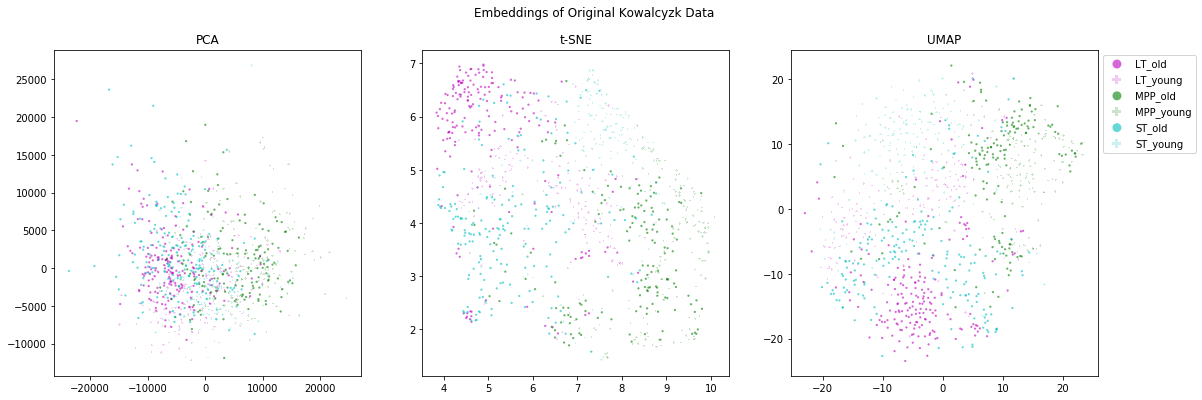

In [6]:
# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Embeddings of Original Kowalcyzk Data')
ax1.set_title('PCA')
ax2.set_title('t-SNE')
ax3.set_title('UMAP')
total_cells = 0
for cell_line, shade in zip(np.unique(y_cell_line), ['m', 'g', 'c']):
    for batch, opacity, marker in zip(np.unique(y_batch), [0.6, 0.2], ['o', 'P']):
        #print(np.where((y_cell_line == cell_line))[0])
        idx = np.where((y_cell_line == cell_line) & (y_batch == batch))[0]
        for embedding, ax in zip([X_pca, X_umap, X_tsne], [ax1, ax2, ax3]):
            X_subset = embedding[idx, :2]
            total_cells += X_subset.shape[0]
            ax.scatter(X_subset[:,0], X_subset[:,1], s=5, c=shade, edgecolors='none', marker=marker, alpha=opacity, label='{}_{}'.format(cell_line, batch))
plt.legend(markerscale=4., loc="upper left", bbox_to_anchor=(1,1))
plt.subplots_adjust(right=0.85)
plt.savefig('Kowalcyzk_embeddings.pdf', bbox='tight')
plt.show

## CellBench

In [7]:
datasets['CellBench'] = defaultdict(dict)
protocols = ['10x', 'CELseq2', 'Dropseq']
for protocol in protocols:
    print(protocol)
    counts = pd.read_csv('data/CellBench/{}_counts.csv'.format(protocol), index_col=0)
    #counts.drop_duplicates(inplace=True)
    meta = pd.read_csv('data/CellBench/{}_meta.csv'.format(protocol), index_col=0)
    counts, meta = remove_doublets(counts, meta)
    counts, meta = filter_cells(counts, meta)
    counts = filter_genes(counts)
    print(counts.shape)
    datasets['CellBench'][protocol]['counts'] = counts
    datasets['CellBench'][protocol]['meta'] = meta

print(datasets['CellBench']['10x']['meta'].columns)

10x
(16468, 895)
CELseq2
(19066, 240)
Dropseq
(14911, 210)
Index(['unaligned', 'aligned_unmapped', 'mapped_to_exon', 'mapped_to_intron',
       'ambiguous_mapping', 'mapped_to_ERCC', 'mapped_to_MT',
       'number_of_genes', 'total_count_per_cell', 'non_mt_percent',
       'non_ribo_percent', 'outliers', 'cell_line', 'cell_line_demuxlet',
       'demuxlet_cls'],
      dtype='object')


In [8]:
# Get intersection of genes in all batches:
geneset = set(datasets['CellBench']['10x']['counts'].index)
for protocol in protocols:
    print(protocol)
    genes = datasets['CellBench'][protocol]['counts'].index
    print(genes[:10])
    genes = set(genes)
    print(len(genes))
    geneset.intersection_update(genes)
    print(len(geneset))
print('Number of genes in common = {}'.format(len(geneset)))
# Now keep only the intersection:
for proto in protocols:
    print(proto)
    #df = datasets['CellBench'][proto][0]
    datasets['CellBench'][proto]['counts'] = datasets['CellBench'][proto]['counts'][datasets['CellBench'][proto]['counts'].index.isin(geneset)]
    # datasets['CellBench'][protocol][0] = datasets['CellBench'][protocol][0].reindex(geneset)
    print(datasets['CellBench'][proto]['counts'].shape)
    #print(datasets['CellBench'][protocol][0])
    print(datasets['CellBench'][proto]['counts'].isnull().values.any())

10x
Index(['ENSG00000272758', 'ENSG00000154678', 'ENSG00000148737',
       'ENSG00000196968', 'ENSG00000134297', 'ENSG00000122674',
       'ENSG00000201413', 'ENSG00000111640', 'ENSG00000130340',
       'ENSG00000224219'],
      dtype='object')
16468
16468
CELseq2
Index(['ENSG00000271259', 'ENSG00000138606', 'ENSG00000270742',
       'ENSG00000177519', 'ENSG00000128655', 'ENSG00000222019',
       'ENSG00000272114', 'ENSG00000213530', 'ENSG00000255236',
       'ENSG00000228203'],
      dtype='object')
19066
15284
Dropseq
Index(['ENSG00000223849', 'ENSG00000225355', 'ENSG00000135093',
       'ENSG00000183579', 'ENSG00000138363', 'ENSG00000175061',
       'ENSG00000128564', 'ENSG00000162073', 'ENSG00000106086',
       'ENSG00000251107'],
      dtype='object')
14911
13378
Number of genes in common = 13378
10x
(13378, 895)
False
CELseq2
(13378, 240)
False
Dropseq
(13378, 210)
False


(1345, 13378)
fitting PCA
fitting UMAP


C:\Users\samir\Anaconda3\envs\point-align\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


fitting tSNE
(1345, 100)


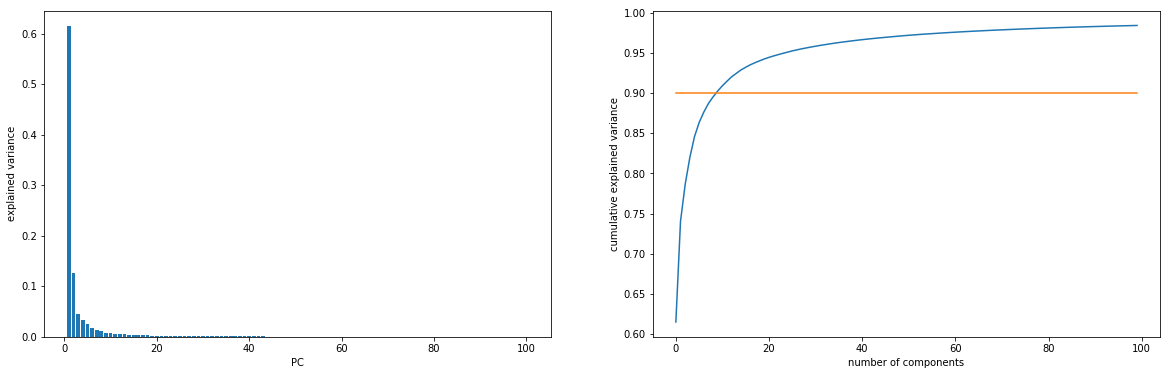

In [9]:
# def embed_dataset(datasets, key):
#     for batch in datasets[key].keys():
#         cur_size = datasets[key][batch][0].shape[1]
#         y_proto.extend([proto]*cur_size)
#         y_cell_line.extend(datasets['CellBench'][proto][1]['cell_line_demuxlet'])
#         X[cur_idx: cur_idx + cur_size] = datasets['CellBench'][proto][0].T
#         cur_idx += cur_size
# Embed
n_cells = np.sum([datasets['CellBench'][proto]['counts'].shape[1] for proto in protocols])
X = np.zeros((n_cells, len(geneset)))
y_proto = []
y_cell_line = []
cur_idx = 0
for proto in protocols:
    cur_size = datasets['CellBench'][proto]['counts'].shape[1]
    y_proto.extend([proto]*cur_size)
    y_cell_line.extend(datasets['CellBench'][proto]['meta']['cell_line_demuxlet'])
    X[cur_idx: cur_idx + cur_size] = datasets['CellBench'][proto]['counts'].T
    cur_idx += cur_size
y_proto = np.array(y_proto)
y_cell_line = np.array(y_cell_line)
assert(len(y_proto) == X.shape[0] and len(y_cell_line) == X.shape[0])
print(X.shape)
#X = StandardScaler().fit_transform(X)
print('fitting PCA')
pca_model = PCA(n_components=N_PC).fit(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
ax1.set_ylabel('explained variance')
ax1.set_xlabel('PC')
ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
ax2.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance')

if DO_STANDARDIZE:
    X = StandardScaler().fit_transform(X)
    print('fitting PCA')
    pca_model = PCA(n_components=N_PC).fit(X)
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
    ax1.set_ylabel('explained variance')
    ax1.set_xlabel('PC')
    ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
    ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('cumulative explained variance')

X_pca = pca_model.transform(X)
pca_scaler = StandardScaler().fit(X_pca)
print('fitting UMAP')
X_umap = umap.UMAP().fit_transform(X)
print('fitting tSNE')
X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_pca.shape)
for proto in protocols:
    datasets['CellBench'][proto]['pca'] = pca_model.transform(datasets['CellBench'][proto]['counts'].T)

<function matplotlib.pyplot.show(*args, **kw)>

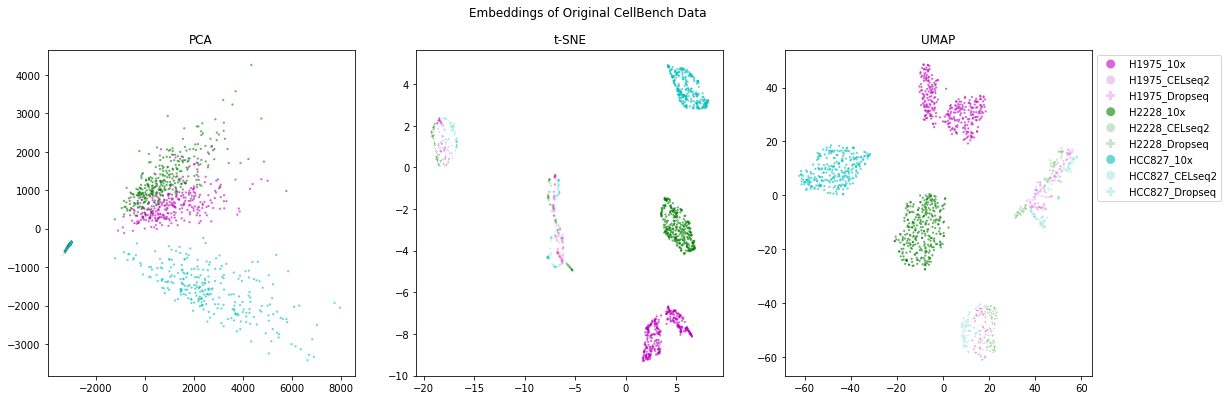

In [10]:
# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Embeddings of Original CellBench Data')
ax1.set_title('PCA')
ax2.set_title('t-SNE')
ax3.set_title('UMAP')
total_cells = 0
for cell_line, shade in zip(np.unique(y_cell_line), ['m', 'g', 'c']):
    for proto, opacity, marker in zip(protocols, [0.6, 0.2, 0.2], ['o', 'o', 'P']):
        #print(np.where((y_cell_line == cell_line))[0])
        idx = np.where((y_cell_line == cell_line) & (y_proto == proto))[0]
        for embedding, ax in zip([X_pca, X_umap, X_tsne], [ax1, ax2, ax3]):
            X_subset = embedding[idx, :2]
            total_cells += X_subset.shape[0]
            ax.scatter(X_subset[:,0], X_subset[:,1], s=5, c=shade, edgecolors='none', marker=marker, alpha=opacity, label='{}_{}'.format(cell_line, proto))
plt.legend(markerscale=4., loc="upper left", bbox_to_anchor=(1,1))
plt.subplots_adjust(right=0.85)
plt.savefig('CellBench_embeddings.pdf', bbox='tight')
plt.show

# 1: Iterative Closest Point

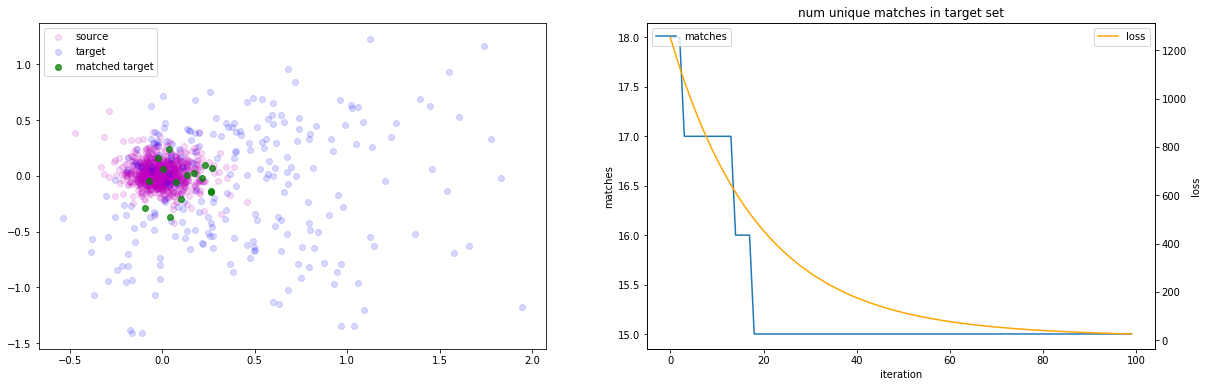

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=False)
)

In [13]:
chosen_dataset = 'CellBench'
batchA = '10x'
batchB = 'CELseq2'

A = datasets[chosen_dataset][batchA]['pca']
B = datasets[chosen_dataset][batchB]['pca']
print('A shape: {}'.format(A.shape))
print('B shape: {B.shape}')
print(A.dtype)

def isnan(x):
    return x != x

def get_rigid_transformer(ndims=N_PC, bias=False):
    model = nn.Sequential(nn.Linear(ndims, ndims, bias=bias))
    print(model[0].weight.data.dtype)
    model[0].weight.data.copy_(torch.eye(ndims))#, dtype=torch.double))
    print(model[0].weight.data.dtype)
    return model

def shift_CoM(A, B):
    A -= A.mean(axis=0)
    B -= B.mean(axis=0)
    return A, B

def closest_point_loss(A, B):
    loss = A.unsqueeze(1) - B.unsqueeze(0)
    loss = loss**2
    loss = loss.mean(dim=-1)
    loss, matches = loss.min(dim=1)
    unique_matches = np.unique(matches.numpy())
    loss = loss.sum()
    return loss, unique_matches

def plot_step(A, B, pca, step, matched_targets, closest_points, losses):
    A = pca.transform(A)
    B = pca.transform(B)
    mask = np.zeros(B.shape[0], dtype=bool)
    mask[matched_targets] = True
    B_matched = B[mask]
    B_unmatched = B[~mask]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.scatter(A[:,0], A[:,1], c='m', label='source', alpha=0.15)
    ax1.scatter(B_unmatched[:,0], B_unmatched[:,1], c='b', label='target', alpha=0.15)
    ax1.scatter(B_matched[:,0], B_matched[:,1], c='g', label='matched target', alpha=0.75)
    ax1.legend()
    ax2.plot(closest_points, label='matches')
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('matches')
    ax2.set_title('num unique matches in target set')
    ax2.legend(loc='upper left')
    ax3 = ax2.twinx()
    ax3.set_ylabel('loss')
    ax3.plot(losses, c='orange', label='loss')
    ax3.legend(loc='upper right')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()
    #time.sleep(0.5)

def ICP(A, B, max_iters=100, sgd_steps=100, tolerance=1e-4):
    #A, B = shift_CoM(A, B)
    A = pca_scaler.transform(A)
    B = pca_scaler.transform(B)
    combined = np.concatenate((A, B))
    pca = PCA(n_components=2).fit(combined)
    A = torch.from_numpy(A).float()
    B = torch.from_numpy(B).float()
    assert(not isnan(A).any() and not isnan(B).any())
    transformer = get_rigid_transformer(A.shape[1])
    optimizer = optim.SGD(transformer.parameters(), lr=1e-3)
    transformer.train()
    hit_nan = False
    num_matches = []
    losses = []
    for i in range(max_iters):
        if hit_nan:
            break
        try:
            A_transformed = transformer(A)
            if isnan(A_transformed).any():
                print('encountered NaNs')
                print(transformer[0].weight.data)
                hit_nan = True
                break
            optimizer.zero_grad()
            loss, unique_matches = closest_point_loss(A_transformed, B)
            losses.append(loss.item())
            num_matches.append(len(unique_matches))
            plot_step(A_transformed.detach().numpy(), B.detach().numpy(), pca, i, unique_matches, num_matches, losses)
            loss.backward()
            optimizer.step()
        except KeyboardInterrupt:
            break
    return transformer
ICP(A, B)

# 2: Relaxed ICP

# 3: Diverse ICP